<a href="https://colab.research.google.com/github/charlesmartin14/theory-paper/blob/main/notebooks/VIT_WW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning Vision Transformers for Image Classification

Just as transformers-based models have revolutionized NLP, we're now seeing an explosion of papers applying them to all sorts of other domains. One of the most revolutionary of these was the Vision Transformer (ViT), which was introduced in [June 2021](https://arxiv.org/abs/2010.11929) by a team of researchers at Google Brain.

This paper explored how you can tokenize images, just as you would tokenize sentences, so that they can be passed to transformer models for training. Its quite a simple concept, really...

1. Split an image into a grid of sub-image patches
1. Embed each patch with a linear projection
1. Each embedded patch becomes a token, and the resulting sequence of embedded patches is the sequence you pass to the model.

![vit_figure.png](https://raw.githubusercontent.com/google-research/vision_transformer/main/vit_figure.png)


It turns out that once you've done the above, you can pre-train and finetune transformers just as you're used to with NLP tasks. Pretty sweet 😎.

---

In this notebook, we'll walk through how to leverage 🤗 `datasets` to download and process image classification datasets, and then use them to fine-tune a pre-trained ViT with 🤗 `transformers`. 

To get started, lets first install both those packages.

In [1]:
from google.colab import drive
drive.mount('/drive')
results_dir = '/drive/MyDrive/setol_paper'

!ls $results_dir

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
alpha_vs_testacc.png  LSA_PL_fit.png	 mlp3_results.feather
bs_vs_testacc.png     LSA_variance.png	 model_bs1
bs_vs_trainacc.png    MLP3_bs16_FC2.png  model_bs16
LSA_detX.png	      MLP3_bs1_FC2.png	 model_bs2
LSA_D_KS.png	      MLP3_bs2_FC2.png	 model_bs32
LSA_evals.png	      MLP3_bs32_FC2.png  model_bs4
LSA_local_ratios.png  MLP3_bs4_FC2.png	 model_bs8
LSA_log_lin_ESD.png   MLP3_bs8_FC2.png	 svd20_vs_testacc.png


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, clear_output


### Load our pretrained model.


**Skipping**: 

 We'll add `num_labels` on init to make sure the model creates a classification head with the right number of units. We'll also include the `id2label` and `label2id` mappings so we have human readable labels in the 🤗 hub widget if we choose to `push_to_hub`.

In [3]:
from transformers import ViTForImageClassification

model_name_or_path = 'google/vit-base-patch16-224-in21k'

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    #um_labels=len(labels),
    #id2label={str(i): c for i, c in enumerate(labels)},
    #label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from weightwatcher import WeightWatcher

watcher = WeightWatcher(model=model) 
details = watcher.describe()
layer_ids = details[details.layer_type=='LAYER_TYPE.DENSE'].layer_id.to_numpy()
layer_ids = details.layer_id.to_numpy()

layer_names = [str(x) for x in layer_ids]
results =  watcher.analyze(layers=layer_ids, detX=True, randomize=True, svd_method="accurate")

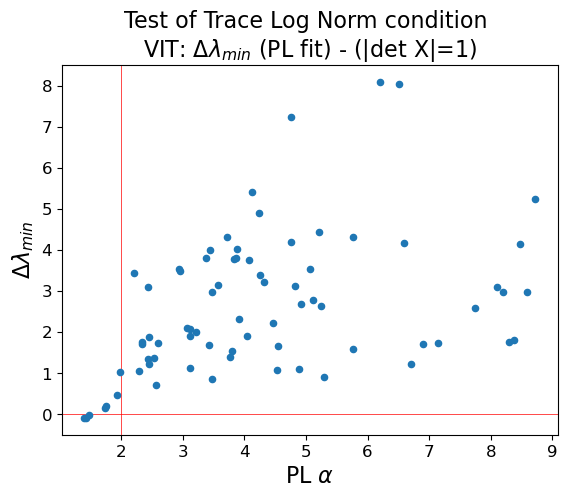

In [6]:
from plot_utils import MEDIUM_SIZE
results.plot.scatter(x='alpha', y='detX_delta')
plt.title("Test of Trace Log Norm condition \n"+r"VIT: $\Delta\lambda_{min}$ (PL fit) - (|det X|=1)", fontdict={'fontsize': MEDIUM_SIZE})
plt.xlabel(r"PL $\alpha$")
plt.ylabel(r"$\Delta\lambda_{min}$")
plt.axvline(2, linewidth=0.5, color="red", zorder=-1)
plt.axhline(0, linewidth=0.5, color="red", zorder=-1)
plt.savefig("VIT_ESD_trends.png")

<AxesSubplot: xlabel='alpha', ylabel='rand_distance'>

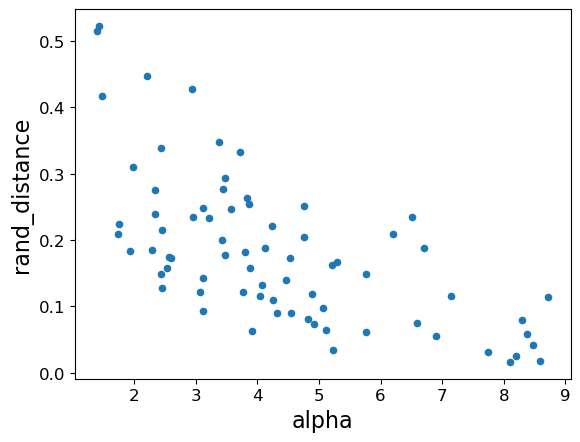

In [14]:
results.plot.scatter(x='alpha',y='rand_distance')

### 3 layers have 1 or more Correlation Traps

The first layer is not fit properly, not analyzeable

In [16]:
results.rand_num_spikes.value_counts()

0      66
1       3
201     1
2       1
3       1
4       1
Name: rand_num_spikes, dtype: int64